In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *
from graph_format import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


In [2]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [3]:
rows_to_drop = np.arange(40+70+55, 40+70+55+15)
cols_to_drop = np.arange(40+70+55, 40+70+55+15)

mean_drop = np.delete(mean, rows_to_drop, axis=0)

weights_drop = np.delete(weights, rows_to_drop, axis=0)
weights_drop = np.delete(weights_drop, cols_to_drop, axis=1)


In [4]:
var1 = np.mean(mean[:40])
var2 = np.mean(mean[40:110])
var3 = np.mean(mean[110:165])
var4 = np.mean(mean[180:])

n = 205
test_weight = np.zeros((n, n))

# fill only the four blocks with 1/var^2
blocks = [
    (0,    40,  var1),
    (40,  110,  var2),
    (110, 165,  var3),
    (180, 205,  var4)
]

for start, end, v in blocks:
    idx = np.arange(start, end)
    test_weight[idx, idx] = 1.0 / (v**2)


In [5]:
def randomize_theta_init(theta_init, bounds, pct=0.05):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1")

theta_init = np.array([0.964943, 1.151436, 1.892169, 6.619750, 7.322572, 0.050859])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               (0.0, 1.0)
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

In [6]:
# # Do SMM
# objective = lambda theta: obj_func(theta, theta_names, mean_drop, weights_drop, model, orig_bounds, do_print=True)

# res = minimize(
#     objective, 
#     theta_init_scaled,
#     method='nelder-mead',
#     bounds=[(0,1)] * len(theta_init_scaled),
#     tol=1e-6,
#     options={"maxiter":2000}
# )


In [7]:
# theta_final

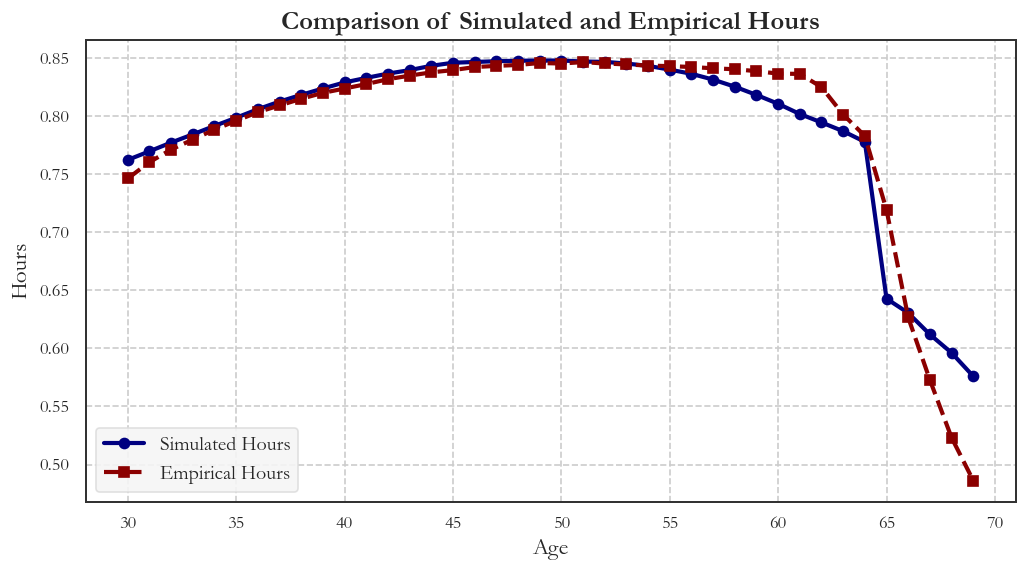

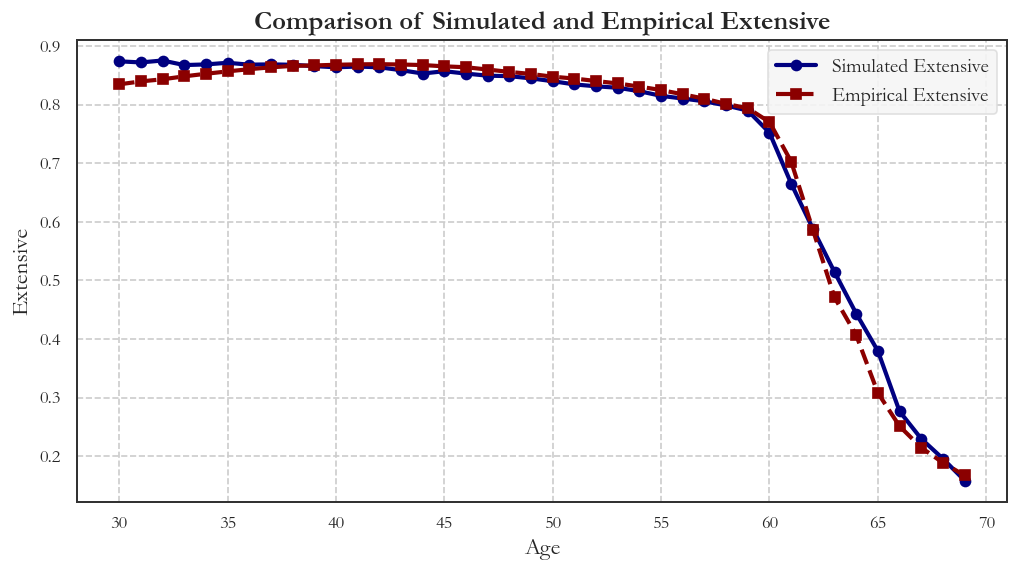

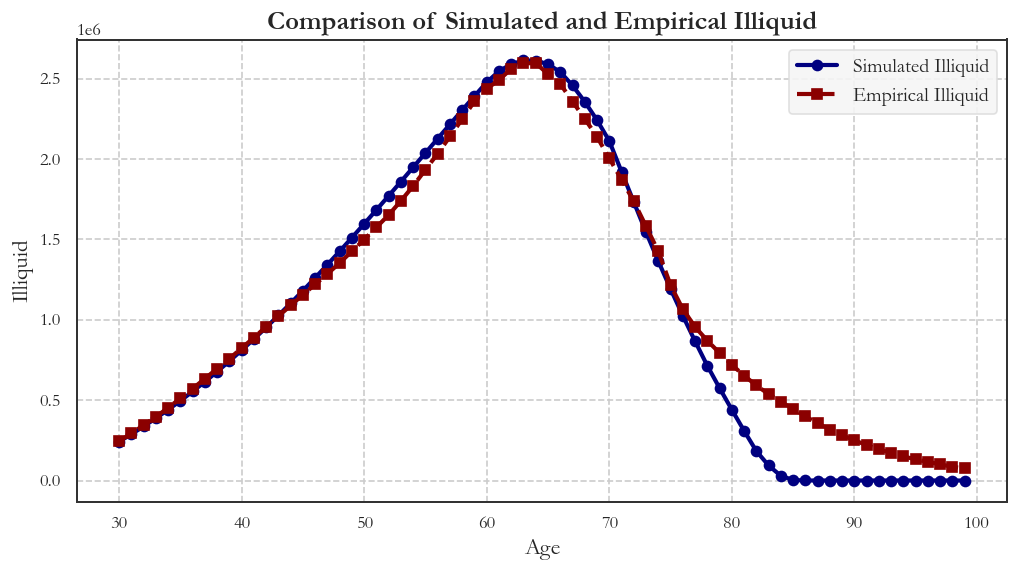

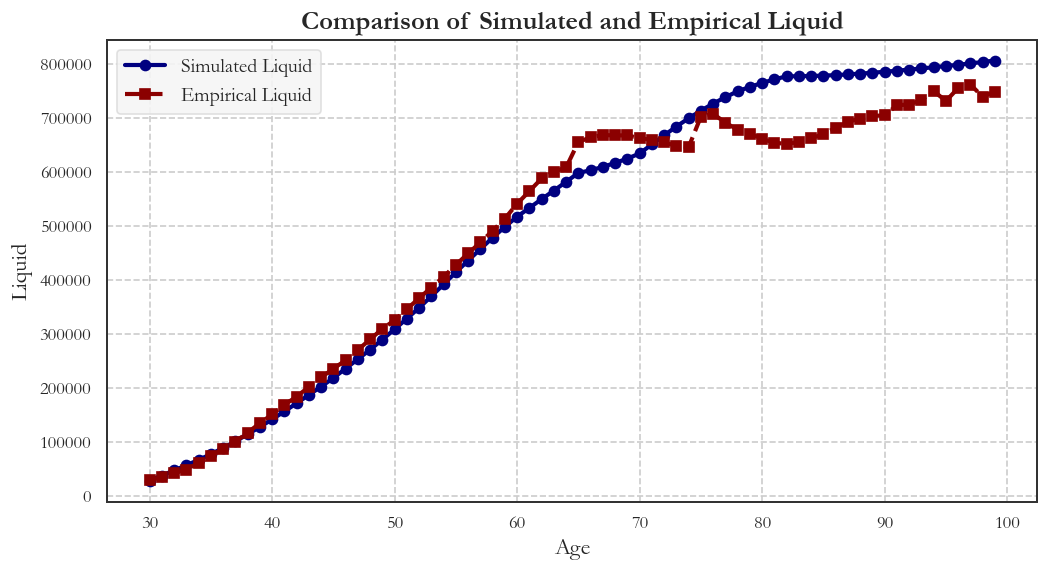

In [8]:
# Load the model with calibrated values
# theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1")
# theta_names = ("beta", "zeta")
# # theta_final = unscale_params(res.x, orig_bounds)
# # theta_final = theta_init

# theta_final = np.array([0.967331, 7.475348])

# for i, name in enumerate(theta_names):
#     setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}


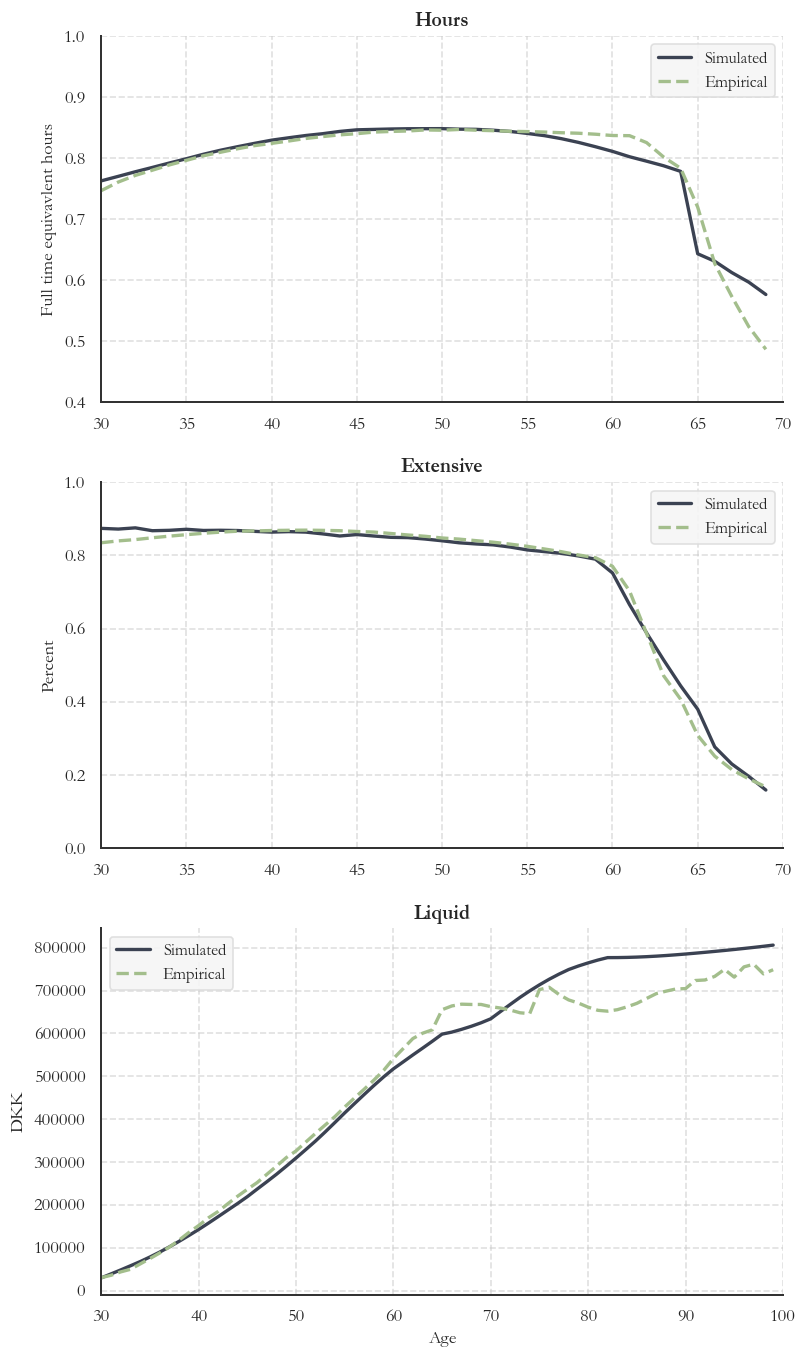

In [10]:
plot_model_vs_data_grid(a_dict, title="", save_title="in_sample_fit.png")


In [11]:
means_data = pd.read_csv("Data/mean_matrix.csv")

b_dict = {
    'illiquid': [np.clip(np.clip(np.mean(model.sim.s, axis=0), 0, None) / 1_000_000, 0, None),
                 moments['savings'] / 1_000_000]  ,
    'wages':    [np.nanmean(np.where(model.sim.ex==1, model.sim.w, np.nan)[:, :31] , axis=0),
                 means_data[means_data["alder"] <= 60]["hourly_salary_plsats_Mean"].to_numpy() * 1924]
        }

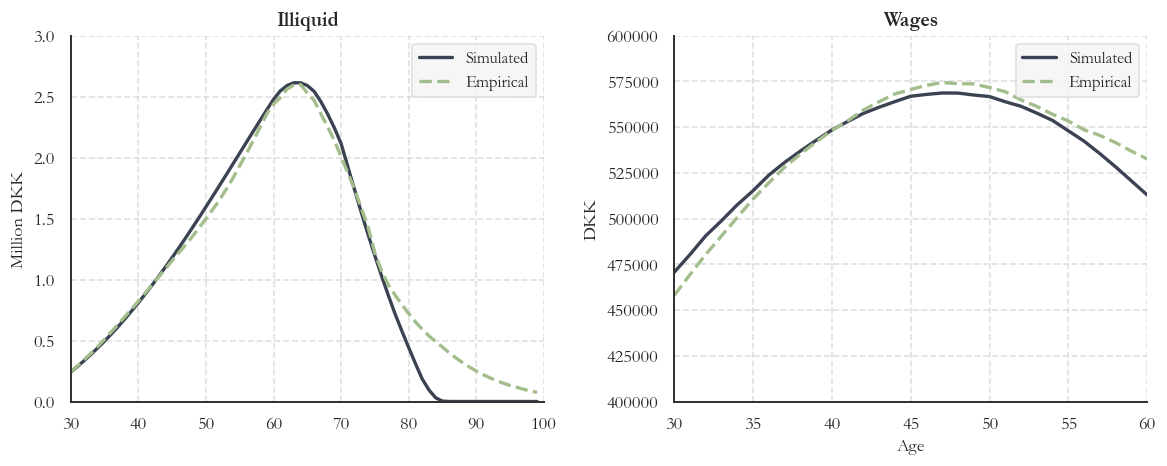

In [12]:
plot_model_vs_data_grid_oos(b_dict, title="", save_title="out_of_sample_fit.png")


Old best variables:

In [13]:
theta_old = ([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])

In [14]:
model.par.pi

array([0.99905664, 0.99903845, 0.99901794, 0.99899484, 0.9989688 ,
       0.99893947, 0.9989064 , 0.99886915, 0.99882717, 0.99877987,
       0.99872656, 0.9986665 , 0.99859882, 0.99852256, 0.99843664,
       0.99833983, 0.99823075, 0.99810785, 0.99796939, 0.9978134 ,
       0.99763767, 0.99743971, 0.99721672, 0.99696553, 0.99668262,
       0.99636399, 0.99600516, 0.99560108, 0.99514612, 0.99463389,
       0.99405729, 0.99340829, 0.99267793, 0.99185614, 0.99093168,
       0.98989193, 0.98872282, 0.98740861, 0.98593176, 0.98427274,
       0.98240981, 0.98031885, 0.97797312, 0.97534306, 0.97239605,
       0.96909624, 0.96540432, 0.96127733, 0.95666858, 0.95152751,
       0.94579968, 0.93942688, 0.93234732, 0.92449592, 0.91580492,
       0.90620451, 0.8956239 , 0.88399253, 0.87124159, 0.85730593,
       0.84212618, 0.82565126, 0.807841  , 0.78866903, 0.76812568,
       0.74622075, 0.72298601, 0.69847728, 0.67277572, 0.64598835])

In [15]:
par.EL

array([50.67083136, 49.71863847, 48.76652993, 47.81459125, 46.86291609,
       45.91160694, 44.96077583, 44.01054516, 43.06104846, 42.1124313 ,
       41.16485221, 40.21848363, 39.27351289, 38.3301433 , 37.3885952 ,
       36.44910707, 35.51193667, 34.57736219, 33.64568339, 32.71722276,
       31.79232662, 30.87136623, 29.95473878, 29.04286837, 28.13620684,
       27.23523446, 26.34046051, 25.45242358, 24.57169173, 23.69886234,
       22.83456159, 21.97944373, 21.13418981, 20.29950607, 19.47612182,
       18.66478679, 17.866268  , 17.08134595, 16.31081033, 15.55545501,
       14.81607248, 14.09344769, 13.38835126, 12.70153221, 12.03371011,
       11.38556689, 10.75773816, 10.15080436,  9.56528156,  9.00161216,
        8.4601553 ,  7.94117715,  7.44484057,  6.97119414,  6.52015952,
        6.09151628,  5.68488208,  5.29968516,  4.93512387,  4.5901046 ,
        4.2631433 ,  3.95220532,  3.65443859,  3.36571931,  3.07985966,
        2.78719087,  2.47195774,  2.10738099,  1.64598835,  1.  

In [16]:
EL_old = np.where((sp := np.cumprod(par.pi)) > 0, np.cumsum(sp[::-1])[::-1] / sp, 0.0)
EL_old

array([50.67083136, 49.71863847, 48.76652993, 47.81459125, 46.86291609,
       45.91160694, 44.96077583, 44.01054516, 43.06104846, 42.1124313 ,
       41.16485221, 40.21848363, 39.27351289, 38.3301433 , 37.3885952 ,
       36.44910707, 35.51193667, 34.57736219, 33.64568339, 32.71722276,
       31.79232662, 30.87136623, 29.95473878, 29.04286837, 28.13620684,
       27.23523446, 26.34046051, 25.45242358, 24.57169173, 23.69886234,
       22.83456159, 21.97944373, 21.13418981, 20.29950607, 19.47612182,
       18.66478679, 17.866268  , 17.08134595, 16.31081033, 15.55545501,
       14.81607248, 14.09344769, 13.38835126, 12.70153221, 12.03371011,
       11.38556689, 10.75773816, 10.15080436,  9.56528156,  9.00161216,
        8.4601553 ,  7.94117715,  7.44484057,  6.97119414,  6.52015952,
        6.09151628,  5.68488208,  5.29968516,  4.93512387,  4.5901046 ,
        4.2631433 ,  3.95220532,  3.65443859,  3.36571931,  3.07985966,
        2.78719087,  2.47195774,  2.10738099,  1.64598835,  1.  

In [17]:
EL = np.where((sp := np.cumprod(par.pi)) > 0, np.cumsum(sp[::-1])[::-1], 0.0)
EL

array([5.06230306e+01, 4.96239739e+01, 4.86258779e+01, 4.76287621e+01,
       4.66326486e+01, 4.56375622e+01, 4.46435312e+01, 4.36505872e+01,
       4.26587661e+01, 4.16681083e+01, 4.06786591e+01, 3.96904700e+01,
       3.87035986e+01, 3.77181101e+01, 3.67340775e+01, 3.57515833e+01,
       3.47707202e+01, 3.37915925e+01, 3.28143175e+01, 3.18390269e+01,
       3.08658689e+01, 2.98950099e+01, 2.89266365e+01, 2.79609583e+01,
       2.69982105e+01, 2.60386565e+01, 2.50825914e+01, 2.41303457e+01,
       2.31822888e+01, 2.22388336e+01, 2.13004412e+01, 2.03676253e+01,
       1.94409583e+01, 1.85210764e+01, 1.76086859e+01, 1.67045693e+01,
       1.58095915e+01, 1.49247066e+01, 1.40509636e+01, 1.31895126e+01,
       1.23416099e+01, 1.15086219e+01, 1.06920281e+01, 9.89342133e+00,
       9.11450575e+00, 8.35709132e+00, 7.62308383e+00, 6.91446984e+00,
       6.23329526e+00, 5.58163695e+00, 4.96156614e+00, 4.37510336e+00,
       3.82416447e+00, 3.31049807e+00, 2.83561557e+00, 2.40071585e+00,
      

In [18]:
np.arange(par.T)+30+EL 

array([80.62303056, 80.62397392, 80.62587793, 80.62876212, 80.63264857,
       80.63756221, 80.64353118, 80.65058721, 80.65876611, 80.66810825,
       80.67865913, 80.69047001, 80.70359864, 80.71811005, 80.73407747,
       80.75158328, 80.7707202 , 80.79159252, 80.8143175 , 80.83902693,
       80.86586894, 80.89500986, 80.92663646, 80.96095832, 80.99821049,
       81.03865647, 81.08259139, 81.13034565, 81.18228876, 81.23883362,
       81.30044117, 81.36762531, 81.4409583 , 81.52107642, 81.60868592,
       81.70456928, 81.80959151, 81.92470657, 82.05096356, 82.18951258,
       82.34160986, 82.50862191, 82.69202812, 82.89342133, 83.11450575,
       83.35709132, 83.62308383, 83.91446984, 84.23329526, 84.58163695,
       84.96156614, 85.37510336, 85.82416447, 86.31049807, 86.83561557,
       87.40071585, 88.00660776, 88.65363513, 89.34160997, 90.06976067,
       90.83670265, 91.6404384 , 92.47839256, 93.3474853 , 94.24424279,
       95.16493957, 96.10576186, 97.06297721, 98.0330931 , 99.01

In [19]:
np.arange(par.T)+30+EL_old

array([ 80.67083136,  80.71863847,  80.76652993,  80.81459125,
        80.86291609,  80.91160694,  80.96077583,  81.01054516,
        81.06104846,  81.1124313 ,  81.16485221,  81.21848363,
        81.27351289,  81.3301433 ,  81.3885952 ,  81.44910707,
        81.51193667,  81.57736219,  81.64568339,  81.71722276,
        81.79232662,  81.87136623,  81.95473878,  82.04286837,
        82.13620684,  82.23523446,  82.34046051,  82.45242358,
        82.57169173,  82.69886234,  82.83456159,  82.97944373,
        83.13418981,  83.29950607,  83.47612182,  83.66478679,
        83.866268  ,  84.08134595,  84.31081033,  84.55545501,
        84.81607248,  85.09344769,  85.38835126,  85.70153221,
        86.03371011,  86.38556689,  86.75773816,  87.15080436,
        87.56528156,  88.00161216,  88.4601553 ,  88.94117715,
        89.44484057,  89.97119414,  90.52015952,  91.09151628,
        91.68488208,  92.29968516,  92.93512387,  93.5901046 ,
        94.2631433 ,  94.95220532,  95.65443859,  96.36

In [20]:
np.cumprod(sp)

array([9.99056641e-01, 9.97154432e-01, 9.94278448e-01, 9.90414232e-01,
       9.85547692e-01, 9.79664994e-01, 9.72752446e-01, 9.64796399e-01,
       9.55783136e-01, 9.45698787e-01, 9.34529253e-01, 9.22260163e-01,
       9.08876863e-01, 8.94364451e-01, 8.78707874e-01, 8.61892109e-01,
       8.43902422e-01, 8.24724761e-01, 8.04346276e-01, 7.82756010e-01,
       7.59945779e-01, 7.35911277e-01, 7.10653434e-01, 6.84180047e-01,
       6.56507717e-01, 6.27664100e-01, 5.97690467e-01, 5.66644568e-01,
       5.34603728e-01, 5.01668105e-01, 4.67963964e-01, 4.33646765e-01,
       3.98903803e-01, 3.63956038e-01, 3.29058713e-01, 2.94500233e-01,
       2.60598822e-01, 2.27696398e-01, 1.96149285e-01, 1.66315512e-01,
       1.38538818e-01, 1.13129939e-01, 9.03463362e-02, 7.03721689e-02,
       5.33008966e-02, 3.91232571e-02, 2.77232875e-02, 1.88843986e-02,
       1.23061754e-02, 7.63070013e-03, 4.47512155e-03, 2.46551853e-03,
       1.26645403e-03, 6.01416850e-04, 2.61556022e-04, 1.03081344e-04,
      

In [21]:
survival_probs = np.cumprod(par.pi)

with np.errstate(divide='ignore', invalid='ignore'):
    EL = np.zeros_like(survival_probs)
    positive = survival_probs > 0
    cumsum_rev = np.cumsum(survival_probs[::-1])[::-1]
    EL[positive] = cumsum_rev[positive] / survival_probs[positive]

EL

array([50.67083136, 49.71863847, 48.76652993, 47.81459125, 46.86291609,
       45.91160694, 44.96077583, 44.01054516, 43.06104846, 42.1124313 ,
       41.16485221, 40.21848363, 39.27351289, 38.3301433 , 37.3885952 ,
       36.44910707, 35.51193667, 34.57736219, 33.64568339, 32.71722276,
       31.79232662, 30.87136623, 29.95473878, 29.04286837, 28.13620684,
       27.23523446, 26.34046051, 25.45242358, 24.57169173, 23.69886234,
       22.83456159, 21.97944373, 21.13418981, 20.29950607, 19.47612182,
       18.66478679, 17.866268  , 17.08134595, 16.31081033, 15.55545501,
       14.81607248, 14.09344769, 13.38835126, 12.70153221, 12.03371011,
       11.38556689, 10.75773816, 10.15080436,  9.56528156,  9.00161216,
        8.4601553 ,  7.94117715,  7.44484057,  6.97119414,  6.52015952,
        6.09151628,  5.68488208,  5.29968516,  4.93512387,  4.5901046 ,
        4.2631433 ,  3.95220532,  3.65443859,  3.36571931,  3.07985966,
        2.78719087,  2.47195774,  2.10738099,  1.64598835,  1.  